In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Other Computer Vision Problems

## Multi-Label Classification

### The Data

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path/'train.csv')  #pd is for pandas library, df is a dataframe contains some info in rows and column
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [5]:
df.iloc[:,0]  #use iloc to access the array

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [6]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [7]:
df['fname']  # can also acces by column name

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [8]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})  #access a smal portion
tmp_df

,a,b
0,1,3
1,2,4


In [9]:
tmp_df['c'] = tmp_df['a']+tmp_df['b'] #add data
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### End sidebar

### Constructing a DataBlock

In [12]:
#an example dataset
a = list(enumerate(string.ascii_lowercase))
a[0], len(a)  # access an entry(showing a tuple) and show the size

((0, 'a'), 26)

In [13]:
#example dataloader
dl_a = DataLoader(a, batch_size=8, shuffle =true)  #create it, can set some options, e.g. batch size and shuffling
b=first(dl_a)  #grab the first mini batch from the iterator, displaying each part of the tuple separately
b

(tensor([ 7, 24, 17, 21,  5, 19,  9, 15]),
 ('h', 'y', 'r', 'v', 'f', 't', 'j', 'p'))

In [14]:
list(zip(b[0],b[1]))  # now create an acual tuple

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [15]:
list(zip(*b)) #Python gives a short cut to do the same as above, where *b basically means insert each element

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [16]:
#but often need to build datasets, because data often doe not come formed as a dataset, e.g. the enumerated list of alphabet
a = list(string.ascii_lowercase)
a[0], len(a)

('a', 26)

In [18]:
dss = Datasets(a) #create a tuple from the data, in this case half the tuple is empty
dss[0]  

('a',)

In [ ]:
# but we should have a way to get the dependent and independent variables

In [19]:
def f1(o): return o+'a'  #dependent
def f2(o): return o+'b'  #independent

In [23]:
dss = Datasets(a, [[f1]]) #create a new datasets passsing in a list of transformation to do
dss[0]

('aa',)

In [26]:
dss = Datasets(a, [[f1,f2]]) #create a new datasets passsing in a list of lists of transformation to do
dss[0]

('aab',)

In [27]:
dss = Datasets(a, [[f1],[f2]]) #create a new datasets passsing a through each F1 and then separately pass through F2
dss[0]

('aa', 'ab')

In [28]:
dls = DataLoaders.from_dsets(dss, batch_size =4)

In [29]:
first(dls.train)

(('ra', 'sa', 'ka', 'wa'), ('rb', 'sb', 'kb', 'wb'))

In [10]:
dblock = DataBlock()  # make empty datablock

In [11]:
dsets = dblock.datasets(df) # pass in the dataframe, which will create a dataset with training and valid, randomly splits with 20% validation

In [30]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [31]:
x,y = dsets.train[0] #return the first row, where it basically just copies the first row twice
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [32]:
x['fname']

'008663.jpg'

In [33]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels']) # but we neeed to force what are the 
#independent(filename) and indepenedent(labels) variables
# lambda creates a function inline, without a name, be careful lambdas are not saved
dsets = dblock.datasets(df)
dsets.train[0]

('007204.jpg', 'cat')

In [34]:
def get_x(r): return r['fname'] # same as above but with explcit functions, do not obtain the same first entry due to random shuffling
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002848.jpg', 'motorbike')

In [35]:
def get_x(r): return path/'train'/r['fname'] #now get the path, so we can open the file and split labels because this is multiclass
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/storage/data/pascal_2007/train/004010.jpg'), ['sofa', 'person'])

In [36]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  #need image block to open image, and multicateogry block
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0] #returns one hot encdoing, so for this output it shows the images that contain the labels for the first entry, 
#that is why there are two ones

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [37]:
idxs = torch.where(dsets.train[0][1]==1.)[0]  #look at first row and dependent variable and look where it is 1, 
#this now matches the 1s shown above
dsets.train.vocab[idxs]

(#2) ['car','person']

In [38]:
def splitter(df):  #datblock randomly splits, but this dataset has training and validation, so we can use these
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [39]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),  #add transforms
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

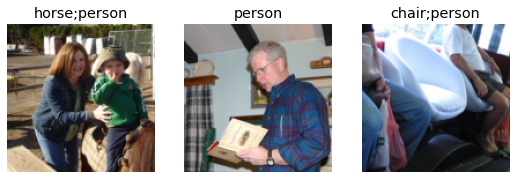

In [40]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [41]:
learn = cnn_learner(dls, resnet18)

In [50]:
x,y = dls.train.one_batch()  # get one batch of the learner
learn.model.cuda() # model moved to CUDA
activs = learn.model(x) # get the model or activations for independent variables
activs.shape  # a minibatch of 64 and 20 categories

torch.Size([64, 20])

In [51]:
activs[0]

TensorImage([ 0.5759, -4.4113, -0.3520, -4.6707, -0.6250, -1.0209,  1.2287, -2.1870,  1.3152, -1.6369, -0.9424,  0.1752,  0.2895,  1.5436, -0.5644, -1.7244,  2.5696,  0.0531,  0.3978,  0.6974],
       device='cuda:0', grad_fn=<AliasBackward>)

In [52]:
def binary_cross_entropy(inputs, targets):  #scale to activtations through this beteen 0 and 1, USing broadcasting applied to each column
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [53]:
loss_func = nn.BCEWithLogitsLoss()  # same as pytorch F.binary_cross_entropy_with_logits for one hot encoded
loss = loss_func(activs, y)
loss

TensorImage(1.0830, device='cuda:0', grad_fn=<AliasBackward>)

In [54]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}." # here we create a simple function to print two strings, 
#with a default that can be explcitly overridden i the function call
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [55]:
f = partial(say_hello, say_what="Bonjour") # here we can override the function with "partial" 
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [56]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2)) #Now we need an accuracy metric threshold to 
#select multiple classes, defaulting to 0.  Automatically chose he loss function
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.931838,0.692817,0.236434,00:27
1,0.816929,0.564515,0.296056,00:27
2,0.595871,0.200865,0.819960,00:27
3,0.357009,0.123669,0.943884,00:27


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131804,0.118761,0.943646,00:32
1,0.117258,0.105821,0.952092,00:32
2,0.097372,0.100453,0.953227,00:32


In [57]:
learn.metrics = partial(accuracy_multi, thresh=0.1) # test different threshold against the validation class, using "Partial"
learn.validate()

(#2) [0.100452721118927,0.9328086972236633]

In [58]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.100452721118927,0.9429880976676941]

In [59]:
preds,targs = learn.get_preds() # get all predictions

In [60]:
accuracy_multi(preds, targs, thresh=0.99, sigmoid=False) # apply a sinlge threshold

TensorImage(0.9430)

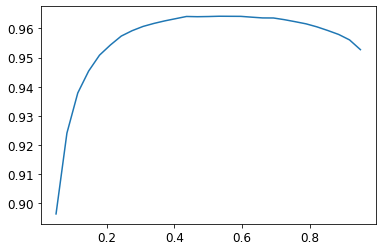

In [61]:
xs = torch.linspace(0.05,0.95,29)  # test many threshold to find the best for the val set
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

Some people may say tuning the the threshold hyperparameter based on the validation set is bad, causing overfitting, but in this case a smooth curve, single value is probably OK

## Regression

### Assemble the Data

In [62]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [63]:
#hide
Path.BASE_PATH = path

In [64]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [65]:
(path/'01').ls().sorted() # returns the image(data) and poses(label)(1000) for 1 of the 25 people

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [66]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('07/frame_00387_pose.txt')

In [67]:
im = PILImage.create(img_files[0])
im.shape #rows x cols

(480, 640)

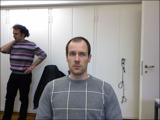

In [68]:
im.to_thumb(160)

In [69]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6) #from authors how to get the center pose
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [70]:
get_ctr(img_files[0])

tensor([318.8099, 230.5128])

In [71]:
biwi = DataBlock(     # this time use pointBlock, which is a tensor with two values, the result of get_ctr above
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),  #make sure the validation set does not include someone in the training
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]  # this is also done by default...
)

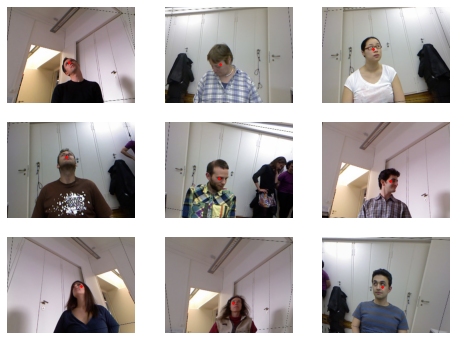

In [72]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [73]:
xb,yb = dls.one_batch()
xb.shape,yb.shape   
#X has 64 in the minibatch, 3 colors, and 240 rows by 320 cols  Y has 64 in the minibatch, and each has an x and y

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [74]:
yb[0]

TensorPoint([[-0.1433,  0.1362]], device='cuda:0')

### Training a Model

In [75]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))  
#remember yrange is the expected range in the independent variable, needed for regressions generally

In [76]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo  # this is how yrange works

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


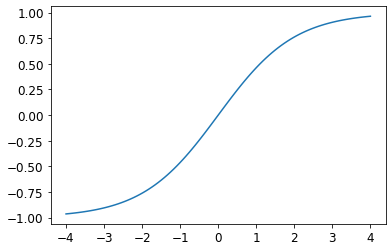

In [77]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4) # and it looks like this, the activations will be mapped here

In [78]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=2.2908675418875646e-06)

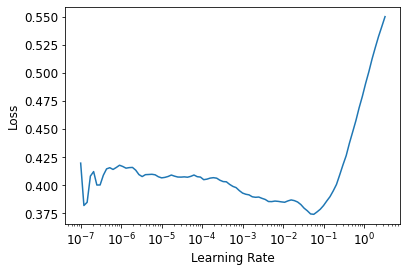

In [79]:
learn.lr_find()

In [80]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.046518,0.021417,03:33


epoch,train_loss,valid_loss,time
0,0.008258,0.009416,04:40
1,0.003491,0.000216,04:40
2,0.001425,0.000064,04:40


In [81]:
math.sqrt(0.0001)

0.01

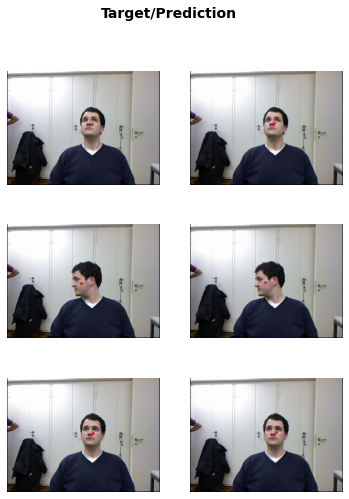

In [82]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your inputs images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.